In [1]:
from neuron import h, gui
import numpy as np
from neuron.units import ms, mV
import matplotlib.pyplot as plt

h.load_file("stdrun.hoc")

%matplotlib inline

In [2]:
class Cell:
    def __init__(self, gid, x, y, z, theta=0):
        self._gid = gid
        self._setup_morphology()
        self.all = self.soma.wholetree()
        self._setup_biophysics()
        self.x = self.y = self.z = 0
        h.define_shape()
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(
                    i,
                    sec.x3d(i),
                    sec.y3d(i),
                    0,
                    sec.diam3d(i),
                )

        self._rotate_z(theta)
        self._set_position(x, y, z)

        self._spike_detector = h.NetCon(self.soma(0.5)._ref_v, None, sec=self.soma)
        self.spike_times = h.Vector()
        self._spike_detector.record(self.spike_times)

        self._ncs = []

        self.soma_v = h.Vector().record(self.soma(0.5)._ref_v)

    def __repr__(self):
        return "{}[{}]".format(self.name, self._gid)

    def _set_position(self, x, y, z):
        for sec in self.all:
            for i in range(sec.n3d()):
                sec.pt3dchange(
                    i,
                    x - self.x + sec.x3d(i),
                    y - self.y + sec.y3d(i),
                    z - self.z + sec.z3d(i),
                    sec.diam3d(i),
                )
        self.x, self.y, self.z = x, y, z

    def _rotate_z(self, theta):
        """Rotate the cell about the Z axis."""
        for sec in self.all:
            for i in range(sec.n3d()):
                x = sec.x3d(i)
                y = sec.y3d(i)
                c = h.cos(theta)
                s = h.sin(theta)
                xprime = x * c - y * s
                yprime = x * s + y * c
                sec.pt3dchange(i, xprime, yprime, sec.z3d(i), sec.diam3d(i))

In [3]:
class PointNeuron(Cell):
    name = "PointNeuron"

    def _setup_morphology(self):
        self.soma = h.Section(name="soma", cell=self)
        self.soma.L = self.soma.diam = 12.6157

    def _setup_biophysics(self):
        for sec in self.all:
            sec.Ra = 100  # Axial resistance in Ohm * cm
            sec.cm = 1  # Membrane capacitance in micro Farads / cm^2
        self.soma.insert("hh")
        for seg in self.soma:
            seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2
            seg.hh.gkbar = 0.036  # Potassium conductance in S/cm2
            seg.hh.gl = 0.0003  # Leak conductance in S/cm2
            seg.hh.el = -54.3  # Reversal potential in mV
        # Insert passive current in the dendrite
        # self.dend.insert("pas")
        # for seg in self.dend:
        #     seg.pas.g = 0.001  # Passive conductance in S/cm2
        #     seg.pas.e = -65  # Leak reversal potential mV

        # NEW: the synapse
        self.syn = h.ExpSyn(self.soma(0.5))
        self.syn.tau = 2 * ms

In [5]:
def create_n_PointNeurons(
    NETDIM_X, NETDIM_Y, NETDIM_Z, x0, y0, z0, Dx=50, Dy=50, Dz=50
):
    # NETDIM_X, NETDIM_Y, NETDIM_Z - number of cells in X, Y and Z dimension
    # x0, y0, z0 – network point of origin
    Dx = Dx
    Dy = Dy
    Dz = Dz

    cells = []
    label = 0
    for i in range(NETDIM_X):
        for j in range(NETDIM_Y):
            for k in range(NETDIM_Z):
                cells.append(PointNeuron(label, x0 + i * Dx, y0 + j * Dy, z0 + k * Dz))
                label = label + 1
    return cells

# SMALL NETWORK


In [96]:
my_cells_E = create_n_PointNeurons(5, 5, 1, 0, 0, 0, 50, 50, 50)

stim = h.NetStim()
syn_ = h.ExpSyn(my_cells_E[0].soma(0.5))
syn_.tau = 2 * ms
syn_.e = 0 * mV
stim.number = 100
stim.interval = 10
stim.start = 0
stim.noise = 1  # 0 – deterministic, 1 – Poisson process

stim.number = 5
stim.interval = 10
stim.start = 0
stim.noise = 1

ncstim = h.NetCon(stim, syn_, 0, 1, 0.005)

In [153]:
netcons_E = []
connections = []
drawn_secs = []
CONNECTION_PROB = 0.2
for source in my_cells_E:
    for target in my_cells_E:
        prob = np.random.uniform()
        if (prob <= CONNECTION_PROB) and (source != target):
            dist = np.sqrt(
                (source.x - target.x) ** 2
                + (source.y - target.y) ** 2
                + (source.z - target.z) ** 2
            )
            nc_E = h.NetCon(source.soma(0.5)._ref_v, target.syn, sec=source.soma)
            nc_E.weight[0] = 0.005
            nc_E.delay = 0.0005 * dist  # 0.0005 [ms/um] -> 2 [m/s]
            print(nc_E.delay)
            netcons_E.append(nc_E)

            sec = h.Section(name=f"{source}_to_{target}")
            sec.diam = 1
            sec.pt3dadd(
                source.x,
                source.y,
                source.z,
                1,
            )
            sec.pt3dadd(
                target.x,
                target.y,
                target.z,
                1,
            )
            drawn_secs.append(sec)

0.075
0.05590169943749474
0.07905694150420949
0.07071067811865475
0.10606601717798214
0.125
0.11180339887498948
0.025
0.05590169943749474
0.07905694150420949
0.1
0.10307764064044152
0.05
0.025
0.09013878188659973
0.05
0.05590169943749474
0.025
0.07071067811865475
0.05590169943749474
0.09013878188659973
0.075
0.11180339887498948
0.10307764064044152
0.075
0.05
0.09013878188659973
0.125
0.05590169943749474
0.07071067811865475
0.09013878188659973
0.09013878188659973
0.125
0.035355339059327376
0.075
0.035355339059327376
0.025
0.05
0.09013878188659973
0.07905694150420949
0.07905694150420949
0.035355339059327376
0.025
0.09013878188659973
0.035355339059327376
0.07905694150420949
0.05590169943749474
0.025
0.05
0.07071067811865475
0.035355339059327376
0.025
0.025
0.09013878188659973
0.05
0.05590169943749474
0.11180339887498948
0.05
0.07905694150420949
0.075
0.025
0.09013878188659973
0.10606601717798214
0.05590169943749474
0.07071067811865475
0.09013878188659973
0.025
0.035355339059327376
0.05590

In [154]:
ps = h.PlotShape(True)
ps.variable("v")
ps.scale(-80, 40)
ps.exec_menu("Shape Plot")
ps.show(0)
h.flush_list.append(ps)

1.0

In [150]:
cell_o_v = h.Vector().record(my_cells_E[0].soma(0.5)._ref_v)

cell_o_v2 = h.Vector().record(my_cells_E[1].soma(0.5)._ref_v)

time = h.Vector().record(h._ref_t)

# h.finitialize(-65 * mV)
# h.continuerun(100 * ms)

In [151]:
# recording spikes
spike_times_vec_E = h.Vector()
idvec_E = h.Vector()
for i, cell in enumerate(my_cells_E):
    nc = h.NetCon(cell.soma(0.5)._ref_v, None, sec=cell.soma)
    nc.record(spike_times_vec_E, idvec_E, i)
del nc

spike_times_stim = h.Vector()
spike_id_stim = h.Vector()
ncstim.record(spike_times_stim, spike_id_stim, 0)

h.finitialize(-65 * mV)
h.continuerun(200 * ms)

0.0

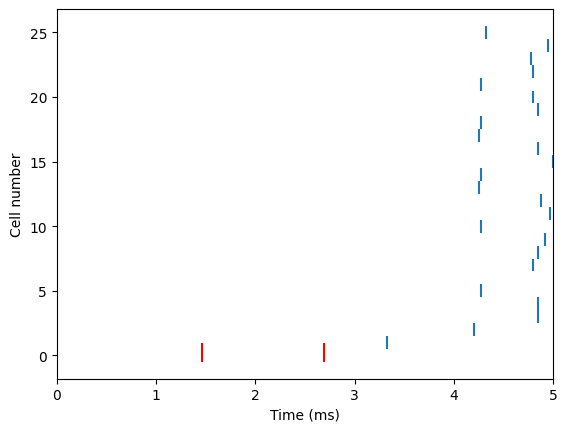

In [155]:
# plotting rasterplot
plt.figure()
plt.vlines(list(spike_times_stim), -0.5, 1, color="r")
for t, id in zip(spike_times_vec_E, idvec_E):
    plt.vlines(t, id + 0.5, id + 1.5)
plt.xlabel("Time (ms)")
plt.ylabel("Cell number")
plt.xlim(0, 5)
plt.show()

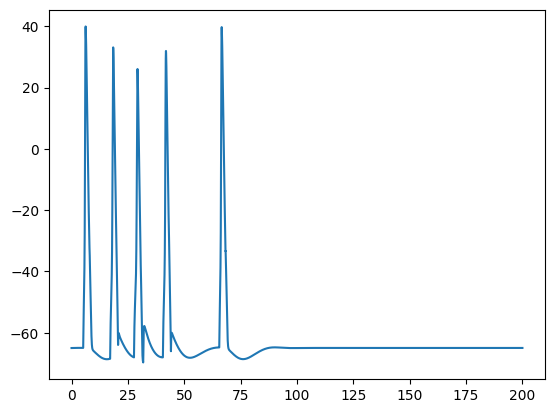

In [136]:
plt.plot(time, cell_o_v, label="cell 0")
plt.show()

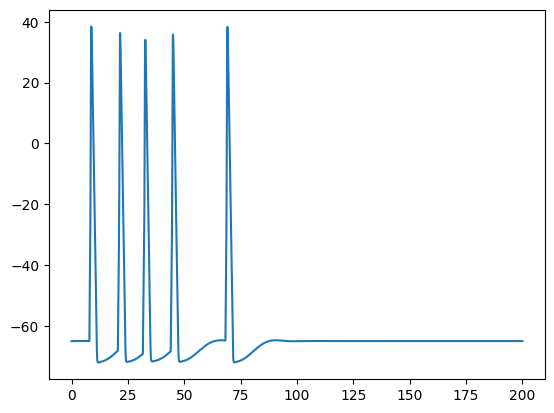

In [137]:
plt.plot(time, cell_o_v2, label="cell 1")
plt.show()

# BIG NETWORK


In [67]:
my_cells_E = create_n_PointNeurons(5, 5, 1, 0, 0, 0, 5000, 5000, 50)

stim = h.NetStim()
syn_ = h.ExpSyn(my_cells_E[0].soma(0.5))
syn_.tau = 2 * ms
syn_.e = 0 * mV
stim.number = 100
stim.interval = 10
stim.start = 0
stim.noise = 1  # 0 – deterministic, 1 – Poisson process

stim.number = 5
stim.interval = 10
stim.start = 0
stim.noise = 1

ncstim = h.NetCon(stim, syn_, 0, 1, 0.005)

In [68]:
cell_o_v = h.Vector().record(my_cells_E[0].soma(0.5)._ref_v)
cell_o_v2 = h.Vector().record(my_cells_E[1].soma(0.5)._ref_v)

In [69]:
netcons_E = []
connections = []
drawn_secs = []
CONNECTION_PROB = 0.2
for source in my_cells_E:
    for target in my_cells_E:
        prob = np.random.uniform()
        if (prob <= CONNECTION_PROB) and (source != target):
            dist = np.sqrt(
                (source.x - target.x) ** 2
                + (source.y - target.y) ** 2
                + (source.z - target.z) ** 2
            )
            nc_E = h.NetCon(source.soma(0.5)._ref_v, target.syn, sec=source.soma)
            nc_E.weight[0] = 0.005
            nc_E.delay = 0.0005 * dist  # 0.0005 [ms/um] -> 2 [m/s]
            netcons_E.append(nc_E)

            sec = h.Section(name=f"{source}_to_{target}")
            sec.diam = 1
            sec.pt3dadd(
                source.x,
                source.y,
                source.z,
                1,
            )
            sec.pt3dadd(
                target.x,
                target.y,
                target.z,
                1,
            )
            drawn_secs.append(sec)

In [70]:
# recording spikes
spike_times_vec_E = h.Vector()
idvec_E = h.Vector()
for i, cell in enumerate(my_cells_E):
    nc = h.NetCon(cell.soma(0.5)._ref_v, None, sec=cell.soma)
    nc.record(spike_times_vec_E, idvec_E, i)
del nc

spike_times_stim = h.Vector()
spike_id_stim = h.Vector()
ncstim.record(spike_times_stim, spike_id_stim, 0)

h.finitialize(-65 * mV)
h.continuerun(200 * ms)

0.0

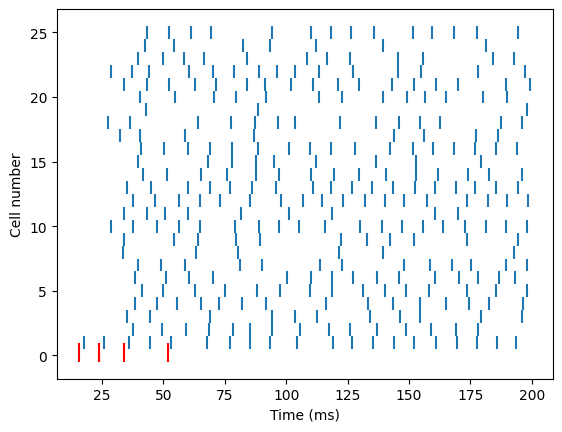

In [71]:
# plotting rasterplot
plt.figure()
plt.vlines(list(spike_times_stim), -0.5, 1, color="r")
for t, id in zip(spike_times_vec_E, idvec_E):
    plt.vlines(t, id + 0.5, id + 1.5)
plt.xlabel("Time (ms)")
plt.ylabel("Cell number")
plt.show()

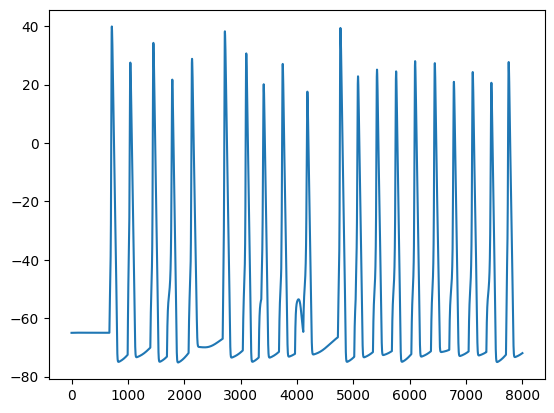

In [72]:
plt.plot(cell_o_v)
plt.show()

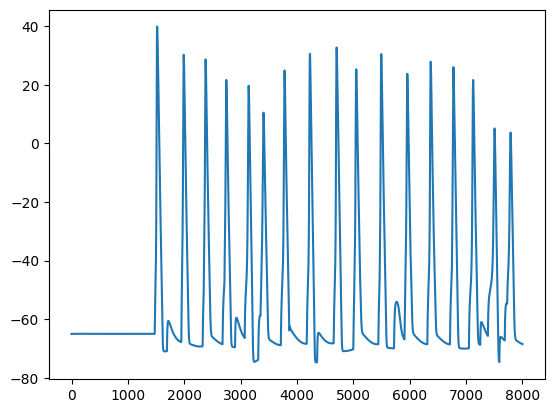

In [73]:
plt.plot(cell_o_v2)
plt.show()